In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [179]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
from numba import njit
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf
from cycler import cycler

In [7]:
from analysis_routines import *
from plotting_routines_xr import *
from harmonic_analysis import *
from wavelet_analysis import wavelet_power_spectrum
from processing_routines import datenum_to_epoch
plt.style.use('/home/manu/TFG_repo/notebooks/mplstyles/notebook.mplstyle')
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf

## Notebook structure and content:
3 periods that exhibit clear tidal variability without strong influence of other processes are selected. For each of them, a spectrogram is computed via the multitapper method. Then the semi diurnal oscilation of D1 and G005 is explored visually applyng diferent filteres to the signal. A single semi-diurnal oscillation is selected and 4 vertical profiles in this interval are ploted. 

In [8]:
def lag_correlation(var1, var2, period=[None, None]):
    slice_ = slice(*period)
    ccf_12 = ccf(var1[slice_], var2[slice_], adjusted=False)
    date = var1[slice_].index.to_numpy()
    lag_hours = (date - date[0])/3.6e12

    fig, ax = plt.subplots()
    ax.plot(lag_hours, ccf_12)
    ax.set_xlabel('lag (h)')
    ax.set_ylabel('correlation')
    
    dt = date[1] - date[0]
    dt = np.timedelta64(dt, 's')/np.timedelta64(1, 's')
    max_ccf = np.argmax(ccf_12)*dt/60/60
    min_ccf = np.argmin(ccf_12)*dt/60/60

    ax.axvline(max_ccf, ls='--', c='grey')
    ax.axvline(min_ccf, ls='--', c='grey')
    print(min_ccf)
    print(max_ccf)

In [9]:
fit_chain = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fci.csv')
data_chain = load_time_series_xr('processed/AGL_20181116_chain_xrcompatible.nc')
G005 = pd.read_csv(data_dir / 'SHDR_fit/aux/G05.csv', index_col='date', parse_dates=True)
delta005 = pd.read_csv(data_dir / 'SHDR_fit/aux/delta05_ci.csv', index_col='date', parse_dates=True)

In [10]:
D1_ = fit_chain.D1
G005_ = G005.x

D1_filt512 = lowpass_filter(fit_chain.D1, data_chain.date, 1/5, 1/512)
G005_filt512 = lowpass_filter(G005.x, data_chain.date, 1/5, 1/512)

D1_filt1024 = lowpass_filter(fit_chain.D1, data_chain.date, 1/5, 1/1024)
G005_filt1024 = lowpass_filter(G005.x, data_chain.date, 1/5, 1/1024)

low = period_to_freq(14, 'h')
high = period_to_freq(8, 'h')
D1_bandpass_M2 = bandpass_filter(fit_chain.D1, data_chain.date, 1/5, low, high)
G005_bandpass_M2 = bandpass_filter(G005.x, data_chain.date, 1/5, low, high)

D1_dn = detrend_normalize(D1_bandpass_M2)
G005_dn = detrend_normalize(G005_bandpass_M2)

hi = period_to_freq(6, 'h')
G005_filt6h = lowpass_filter(G005.x, data_chain.date, 1/5, hi)
D1_filt6h = lowpass_filter(fit_chain.D1, data_chain.date, 1/5, hi)

In [153]:
# dates defining_periods
date_0 = datetime(2018, 11, 16, 11) # period_1
date_1 = datetime(2018, 11, 24)
period_1 = [date_0, date_1]

date_2 = datetime(2018, 11, 30) # period_2
date_3 = datetime(2018, 12, 9)
period_2 = [date_2, date_3]

date_4 = datetime(2019, 1, 5) # period_3
date_5 = datetime(2019, 1, 14)
period_3 = [date_4, date_5]

In [142]:
coriolis_frequency = 2*7.2921e-5*np.sin(np.deg2rad(data_chain.lat.data)[0])
coriolis_freq_cps = coriolis_frequency/2/np.pi
coriolis_freq_cpd = coriolis_freq_cps*60*60*24
M2_cpd = 1/12.42061*24
M4_cpd = 1/6.210301*24
K1_cpd = 1/23.934470*24
Q1_cpd = 1/28.006223*24
M3_cpd = 1/8.280401*24
M8_cpd = 1/3.105150*24
O1_cpd = 1/1/25.819351*24 # not present in temperature record
Q1_2_cpd = 1/28.006223*24
M6_cpd = 1/4.14020*24

## Period_1

In [56]:
p1D_freqs, p1D_psd, p1D_dof = multitapping_spectrum(D1_[:date_1].to_numpy(), 5/60/60/24, 3)
p1G_freqs, p1G_psd, p1G_dof = multitapping_spectrum(G005_[:date_1].to_numpy(), 5/60/60/24, 3)

DPSS using interpolation 130321 100000


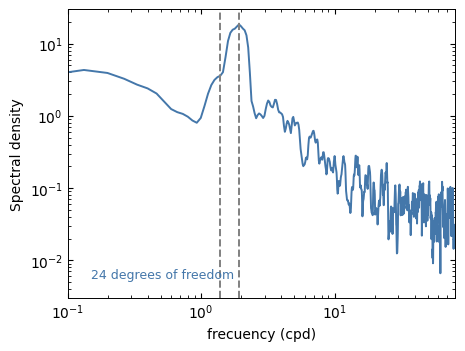

In [148]:
plot_spectrum(p1D_freqs, p1D_psd, p1D_dof, 'cpd', xlim=(1e-1, 8e1), ylim=(3e-3, 3e1), 
              vlines=[M2_cpd, coriolis_freq_cpd])

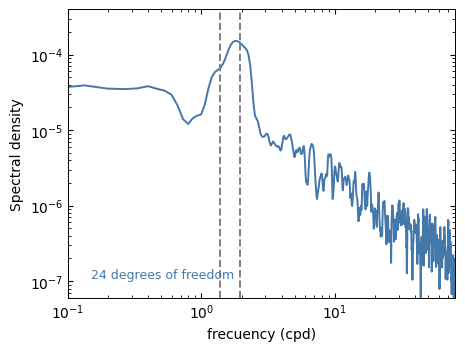

In [149]:
plot_spectrum(p1G_freqs, p1G_psd, p1G_dof, 'cpd', xlim=(1e-1, 8e1), ylim=(6e-8, 4e-4), 
              vlines=[M2_cpd, coriolis_freq_cpd])

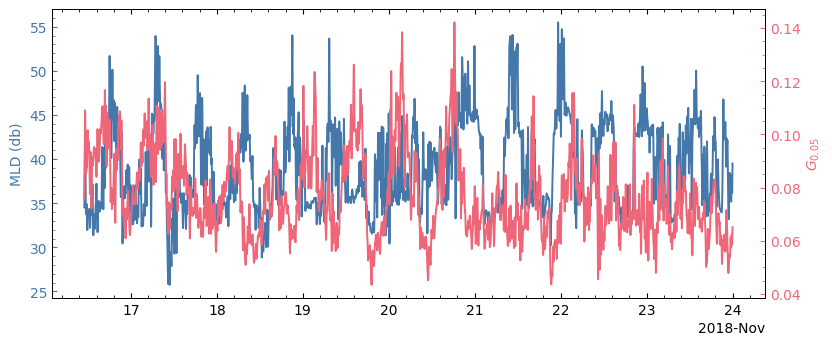

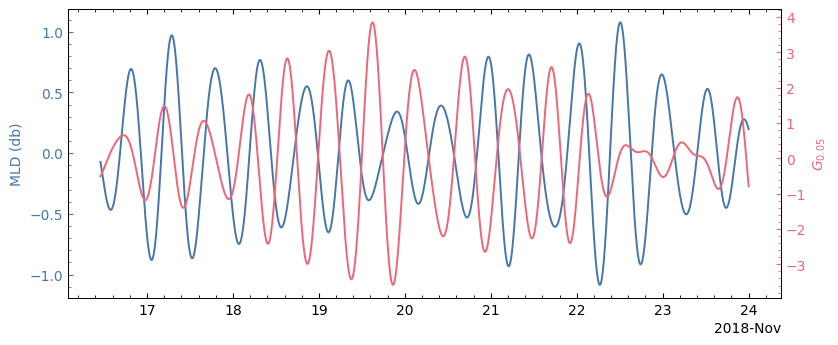

In [185]:
plot_D1_and_G005(D1_filt1024, G005_filt1024, period=period_1)
plot_D1_and_G005(D1_dn, G005_dn, period=period_1)

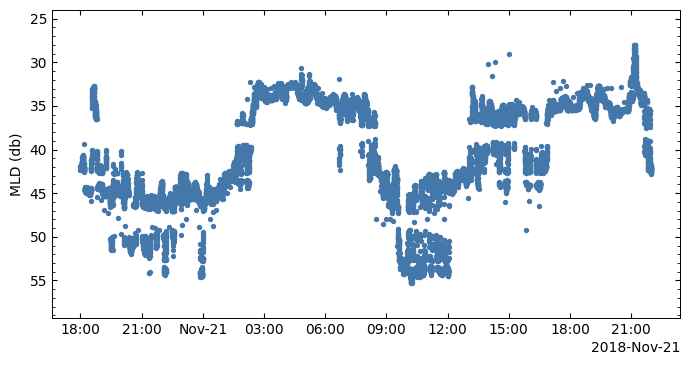

In [94]:
plot_fit_variable(fit_chain, 'D1', period=[datetime(2018, 11, 20, 18), datetime(2018, 11, 21, 22)])

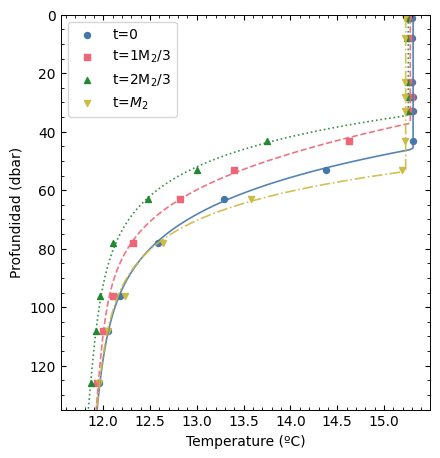

In [148]:
ref_date = datetime(2018, 11, 20, 21, 32, 10)
i_dates = [ref_date + timedelta(hours=i*12.42/3) + timedelta(seconds=i*1) for i in range(4)]
#i_dates = [ref_date + timedelta(hours=i*12.4/4) for i in range(4)]

plot_multiple_profiles_ax(fit_chain, data_chain, i_dates)

In [ ]:
lag_correlation(D1_dn, G005_dn, period=period_1)

## Period_2

In [190]:
p2D_freqs, p2D_psd, p2D_dof = multitapping_spectrum(D1_[date_2:date_3].to_numpy(), 5/60/60/24, 3)
p2G_freqs, p2G_psd, p2G_dof = multitapping_spectrum(G005_[date_2:date_3].to_numpy(), 5/60/60/24, 3)

DPSS using interpolation 155521 100000
DPSS using interpolation 155521 100000


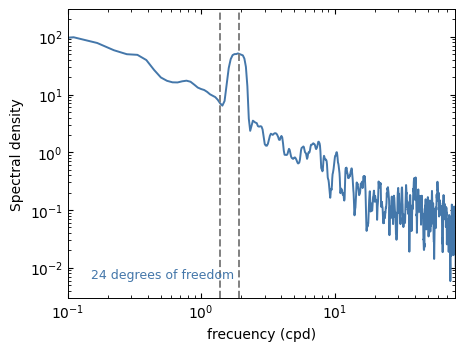

In [195]:
plot_spectrum(p2D_freqs, p2D_psd, p2D_dof, 'cpd', xlim=(1e-1, 8e1), ylim=(3e-3, 3e2), 
              vlines=[M2_cpd, coriolis_freq_cpd])

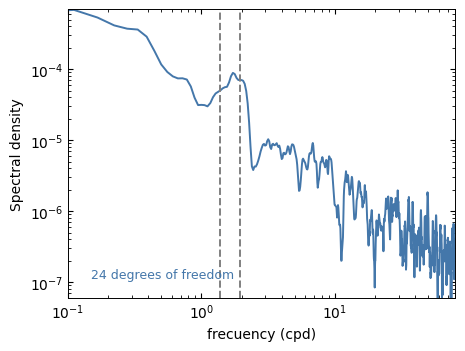

In [196]:
plot_spectrum(p2G_freqs, p2G_psd, p2G_dof, 'cpd', xlim=(1e-1, 8e1), ylim=(6e-8, 7e-4), 
              vlines=[M2_cpd, coriolis_freq_cpd])

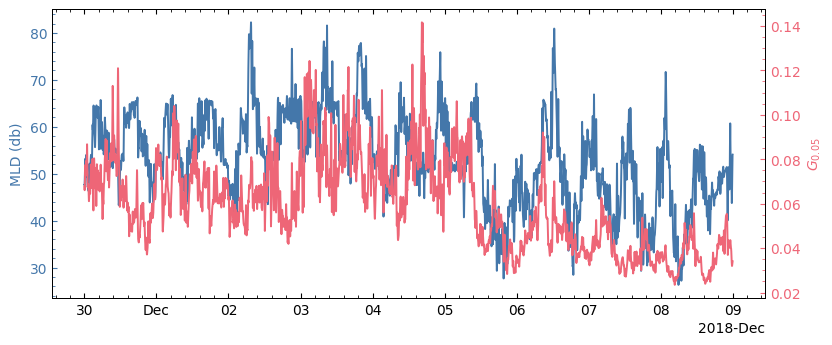

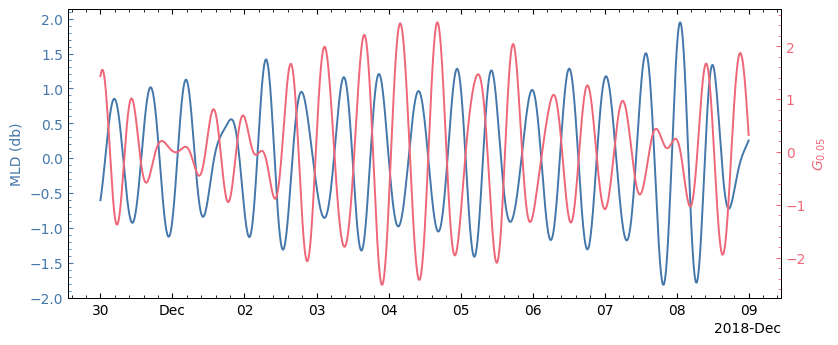

In [193]:
plot_D1_and_G005(D1_filt1024, G005_filt1024, period=period_2)
plot_D1_and_G005(D1_dn, G005_dn, period=period_2)

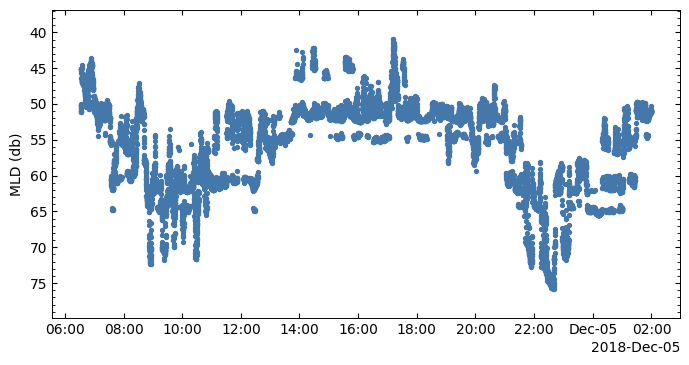

In [108]:
plot_fit_variable(fit_chain, 'D1', period=[datetime(2018, 12, 4, 6, 32, 10), datetime(2018, 12, 5, 2)])

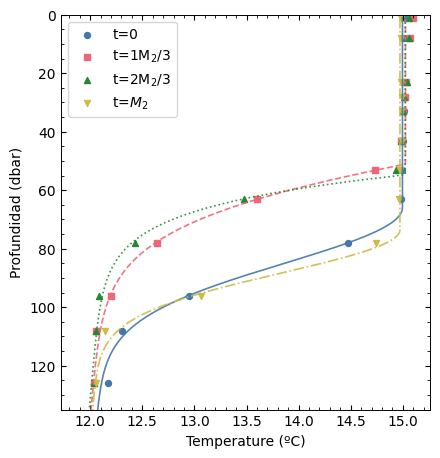

In [149]:
#ref_date = datetime(2018, 12, 3, 20, 4, 10)
ref_date = datetime(2018, 12 ,4, 9, 59, 40)
i_dates = [ref_date + timedelta(hours=i*12.42/3) + timedelta(seconds=i*1) for i in range(4)]
plot_multiple_profiles_ax(fit_chain, data_chain, i_dates)

24.43472222222222
18.313888888888886


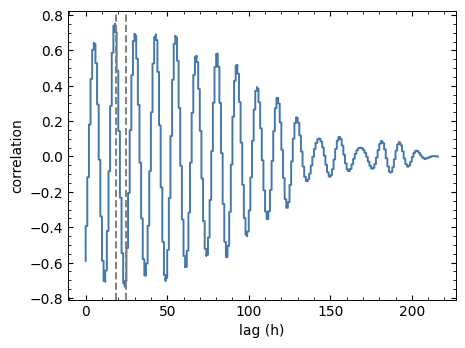

In [194]:
lag_correlation(D1_dn, G005_dn, period=period_2)

## Period_3

In [197]:
p3D_freqs, p3D_psd, p3D_dof = multitapping_spectrum(D1_[date_4:date_5].to_numpy(), 5/60/60/24, 3)
p3G_freqs, p3G_psd, p3G_dof = multitapping_spectrum(G005_[date_4:date_5].to_numpy(), 5/60/60/24, 3)

DPSS using interpolation 155521 100000
DPSS using interpolation 155521 100000


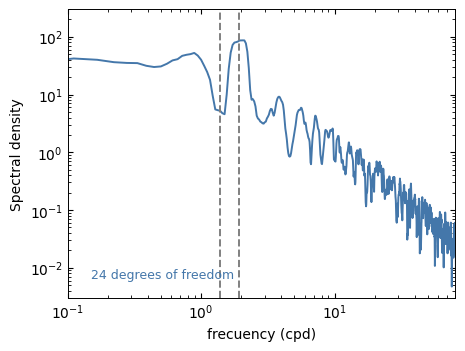

In [198]:
plot_spectrum(p3D_freqs, p3D_psd, p3D_dof, 'cpd', xlim=(1e-1, 8e1), ylim=(3e-3, 3e2), 
              vlines=[M2_cpd, coriolis_freq_cpd])

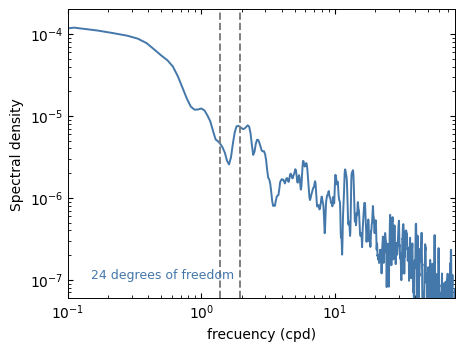

In [203]:
plot_spectrum(p3G_freqs, p3G_psd, p3G_dof, 'cpd', xlim=(1e-1, 8e1), ylim=(6e-8, 2e-4), 
              vlines=[M2_cpd, coriolis_freq_cpd])

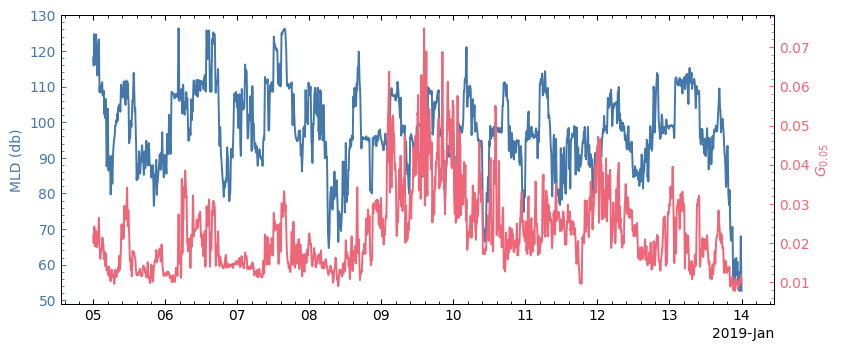

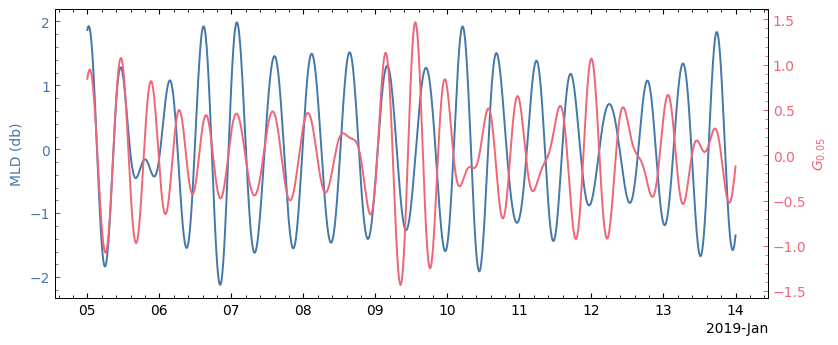

In [204]:
plot_D1_and_G005(D1_filt1024, G005_filt1024, period=period_3)
plot_D1_and_G005(D1_dn, G005_dn, period=period_3)

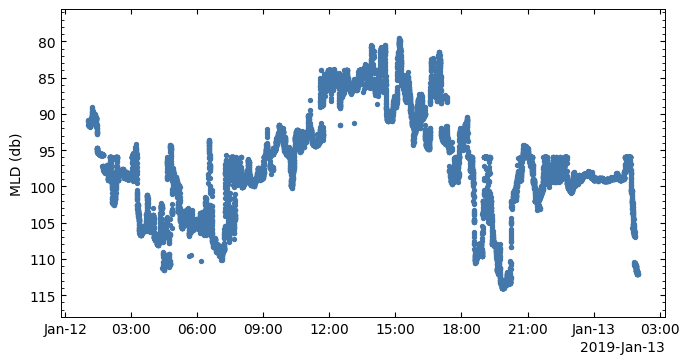

In [132]:
plot_fit_variable(fit_chain, 'D1', period=[datetime(2019, 1, 12, 1, 3, 10), datetime(2019, 1, 13, 2)])

[datetime.datetime(2019, 1, 12, 5, 55, 40), datetime.datetime(2019, 1, 12, 10, 4, 5), datetime.datetime(2019, 1, 12, 14, 12, 30), datetime.datetime(2019, 1, 12, 18, 20, 55)]


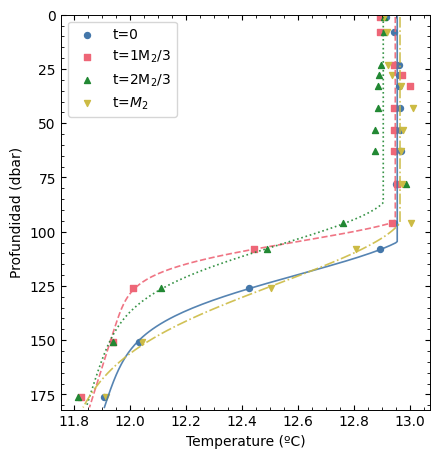

date
2019-01-12 05:55:40    0.020066
2019-01-12 10:04:05    0.032069
2019-01-12 14:12:30    0.017635
2019-01-12 18:20:55    0.014494
Name: x, dtype: float64


In [146]:
ref_date = datetime(2019, 1, 12, 5, 55, 40)
i_dates = [ref_date + timedelta(hours=i*12.42/3) + timedelta(seconds=i*1) for i in range(4)]
print(i_dates)
plot_multiple_profiles_ax(fit_chain, data_chain, i_dates, ylim=(182, 0))
print(G005.x[i_dates])

In [150]:
lag_correlation(D1_dn, G005_dn, period=period_3)

NameError: name 'period_3' is not defined

In [184]:
data_chain.depth

<xarray.DataArray 'depth' (depth: 16)>
array([  1,   8,  23,  28,  33,  43,  48,  53,  63,  78,  96, 108, 126, 151,
       176, 201], dtype=int32)
Coordinates:
  * depth    (depth) int32 1 8 23 28 33 43 48 53 63 78 96 108 126 151 176 201

In [182]:
def quality_index(MLD, y, z, interpolation=False):

    z = z[np.isfinite(y)]
    y = y[np.isfinite(y)]
    
    if interpolation:      
        zz = np.array([13, 18, 38, 48, 58, 68, 73, 84, 90, 102, 114, 
                    120, 131, 136, 141, 146, 156, 161, 166, 171])
        zz = np.linspace(0, max(z), int(max(z)))
        z, y = interpolate(z, y, zz, True)
        
    idx_MLD = np.searchsorted(z, MLD)
    z_ML = z[:idx_MLD]
    y_ML = y[:idx_MLD]
    idx_1_5_MLD = np.searchsorted(z, 1.8*MLD)
    
    if idx_1_5_MLD == len(z) or idx_1_5_MLD==idx_MLD or idx_MLD==0:
        return np.nan

    if idx_1_5_MLD - idx_MLD < 3:
        return np.nan

    z_1_5 = z[:idx_1_5_MLD]
    y_1_5 = y[:idx_1_5_MLD]
    
    return 1 - np.std(y_ML)/np.std(y_1_5)

In [183]:
QI_p1 = [quality_index(fit_chain.D1.loc[i], data_chain.temp.loc[i].data, data_chain.depth.data)
         for i in data_chain.date.loc[slice(*period_1)].data]

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'interpolate':[0m [1m[1mCannot determine Numba type of <class 'function'>[0m
[1m
File "../../../../../tmp/ipykernel_6881/1313555444.py", line 11:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

In [176]:
QI=[]
for k, i in enumerate(data_chain.date.loc[slice(None, datetime(2018, 11, 18))].data):
    QI.append(quality_index(fit_chain.D1.loc[i], data_chain.temp.loc[i].data, data_chain.depth.data))

KeyboardInterrupt: 

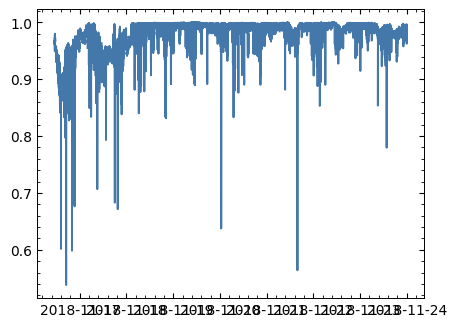

In [166]:
plt.plot(data_chain.date.loc[slice(*period_1)].data, QI_p1)

In [163]:
data_chain.depth

<xarray.DataArray 'depth' (depth: 16)>
array([  1,   8,  23,  28,  33,  43,  48,  53,  63,  78,  96, 108, 126, 151,
       176, 201], dtype=int32)
Coordinates:
  * depth    (depth) int32 1 8 23 28 33 43 48 53 63 78 96 108 126 151 176 201